<img align="left" src="https://statics.phbs.pku.edu.cn/uploadfile/2018/0119/20180119080526567.png" style="margin-top:50px">
<h1 align="right" style="margin-top:60px">Machine Learning for Finance (FIN 570) </h1>
<h1 align="right" style="margin-top:20px">Module 1, 2021-2022 Fall </h1>

<h1 align="center" style="margin-top:40px">Sentiment Analysis on Central Bank Statement</h1>

<center>
<font color=black size=4 face=times> Team: Hu Xueyang & Zhai Sihan<br>
    Instructor: Jaehyuk Choi<br>
<font color=black size=3 face=times><center>(Last Modified on Nov 21, 2021)
<center>

## 1. Introduction

1. **X:** After we develop crawlers to download documents from FOMC website (Chapter 2), we extract information from the documents with both Doc2Vec (Chapter 3) and Latent Dirichlet Allocation (LDA, Chapter 4). Then we calculate the difference between two consecutive statements (Chapter 5.1) and principal components of the difference (Chapter 5.2), Both of which are used for our prediction models.
2. **Y:** We download Federal Funds Rate, short-term and long-term treasury bond yields from Bloomberg (Chapter 5.3). Then we construct Y variables in two ways, i.e. discrete variables and continuous variables (Chapter 5.4).
3. **Influence of Statements:** We first plot the influence of the publication of statements on Y (Chapter 6.1). 
    1. Discrete Y: For discrete Y, we use Random Forest (Chapter 6.2 for original vectors and Chapter 6.3 for principal components), Support Vector Machine (SVM, Chapter 6.4 for original vectors and Chapter 6.5 for principal components) and Dense Neural Network (Chapter 6.6) to do prediction. We also adopt Grid Search to look for appropriate hyper-parameters, and test the accuracy of our model with 5-fold method.
    2. Continuous Y: For continuous Y, we use Dense Neural Network to do prediction (Chapter 6.7).
4. **Findings:** 
    1. Discrete Y: SVM works the best for Federal Funds Rate, while Random Forest and Dense Neural Network work the best for Bond Yields. Models of principal components cannot beat those of original vectors.
    2. Continuous Y: Dense Neural Network model works significantly better for Bond Yields (especially for the 10-year treasury bond yield) than for Federal Funds Rate.
    3. Similartiy between documents: The cosine similarity based on Doc2Vec model outputs is low and volatile, while the similarity based on LDA model outputs is higher and smoother. Similarity between two consecutive statements is much higher than that between two minutes or between the statement and minutes of the same meeting.

## 2. Collect HTML Files from FOMC Website

##### Please see [Web Crawler.ipynb]() under the same repository.

## 3. Analyze HTML Files with Doc2Vec Model

##### We first tried PDF documents before the presentation (see [PDF Processor.ipynb]()). However, due to the limited number of pdf files available, we tried HTML files after the presentation.

### 3.1 Define functions to preprocess HTML files

Define functions to read HTML files.

In [164]:
from bs4 import BeautifulSoup as bs
import unicodedata
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import os
import numpy as np
import pandas as pd
import re

def html_to_str(file):
    with open(file,encoding='ISO-8859-1') as f:
        contents = f.read().replace('\n',' ').replace('\t',' ')
        clean_text = unicodedata.normalize('NFKD',bs(contents, 'lxml').get_text())
    return clean_text

### 3.2 Construct training samples for Doc2Vec model

In [165]:
html_min_path='./html_min/'
html_stat_path='./html_stat/'
html_min_list=os.listdir(html_min_path)
html_stat_list=os.listdir(html_stat_path)
html_min_list=[i for i in html_min_list if not i.startswith('.')]
html_stat_list=[i for i in html_stat_list if not i.startswith('.')]

In [172]:
# construct TaggedDocument data with sentences
def str_to_sentences(string, tag=False):
    train_content = []
    count = 0
    if string == '':
        print('Cannot process empty string. Please check.')
    else:
        if tag == True:
            for item in string.split('. '):
                try:
                    train_content.append(TaggedDocument(item, [str(count)]))
                    count += 1
                except ValueError:
                    pass
            return train_content
        else:
            for item in string.split('. '):
                try:
                    train_content.append(item)
                except ValueError:
                    pass
            return train_content

In [166]:
# construct TaggedDocument data with documents
def label_doc(docs, labels, tag=True):
    train_content = []
    if tag == True:
        for count, item in enumerate(docs):
            try:
                train_content.append(TaggedDocument(item, [labels[count]]))
            except ValueError:
                pass
        return train_content
    else:
        for item in docs:
            try:
                train_content.append(item)
            except ValueError:
                pass
        return train_content

In [167]:
html_raw_contents = []
for file in html_min_list:
    contents = html_to_str(html_min_path + file)
    html_raw_contents.append(contents)

for file in html_stat_list:
    contents = html_to_str(html_stat_path + file)
    html_raw_contents.append(contents)

train_data  = label_doc(html_raw_contents, html_min_list + html_stat_list)

### 3.3 Build and train a Doc2Vec model

Distributed Memory Model of Paragraph Vectors (PV-DM) by Le and Mikolov (2014):

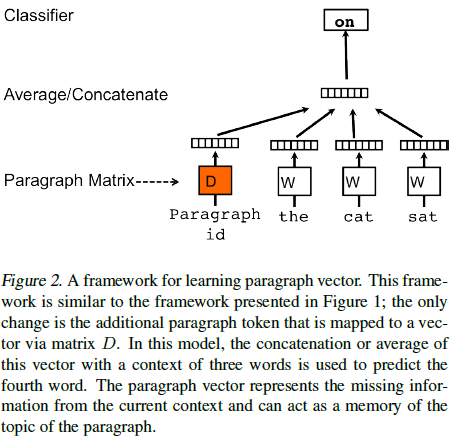

In [168]:
# initialize a Doc2Vec model using distributed memory method
model_html = Doc2Vec(dm=1, vector_size=20, window=5, min_count=2, workers=4)

In [170]:
# train and save the model
model_html.build_vocab(train_data)
model_html.train(train_data, total_examples=model_html.corpus_count, epochs=50)
model_html.save('doc2vec_html.model')

### 3.4 Obtain document vectors

In [173]:
# obtain doc vectors for statements
vec_stat = pd.DataFrame(np.zeros([len(html_stat_list), model_html.vector_size]))

for i in range(len(html_stat_list)):
    file = html_stat_list[i]
    if re.findall(r'\d{8}', file) is not None:
        contents = html_to_str(html_stat_path + file)
        test_content = str_to_sentences(contents, tag=False)
        vec = model_html.infer_vector(test_content)
        vec_stat.loc[i, 'file'] = file.split('.', 1)[0]
        vec_stat.iloc[i, : model_html.vector_size] = vec
        vec_stat.loc[i, 'date'] = re.findall(r'\d{8}', file)
    else:
        pass
vec_stat.set_index('date', inplace=True)
vec_stat.to_excel('vec_stat_html.xlsx')
vec_stat=vec_stat.sort_index()
vec_stat.index=pd.to_datetime(vec_stat.index)
vec_stat

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,file
date,,,,,,,,,,,,,,,,,,,,,
1994-02-04,0.016943,-0.000095,-0.005788,-0.013099,0.022028,-0.014958,-0.003076,-0.004720,0.015610,-0.021061,...,-0.020582,-0.020922,0.017514,-0.022940,0.018460,0.020110,0.018745,-0.009111,0.023471,19940204
1994-03-22,-0.002089,-0.021057,0.000333,-0.023966,-0.007958,-0.021377,0.011231,0.000263,-0.002541,-0.012344,...,0.015612,-0.024421,-0.008966,0.018002,-0.013489,0.001934,-0.011387,-0.006658,-0.011776,19940322
1994-04-18,-0.023936,-0.001341,-0.016499,0.014938,-0.021226,0.001396,0.001154,0.019712,-0.024972,-0.005961,...,0.006243,-0.000627,-0.013831,0.023804,-0.007107,0.021300,0.005348,0.002764,-0.018759,19940418
1994-05-17,0.003793,0.013395,0.001036,0.022215,0.015733,0.017659,0.010572,-0.017560,-0.000508,0.023359,...,0.019181,0.008081,0.017448,0.023621,-0.007887,0.010828,0.021600,-0.004796,-0.017557,19940517
1994-08-16,0.010390,-0.006094,0.007997,-0.009483,0.021099,-0.010789,0.000430,0.010479,0.008984,0.011899,...,0.004194,-0.004169,0.019072,0.018989,-0.011923,-0.003650,-0.003483,0.014141,-0.002529,19940816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-28,-0.000155,-0.022977,-0.009413,-0.021783,0.008526,-0.008576,0.005393,0.000821,0.022470,-0.008346,...,0.017553,-0.000138,0.016221,-0.018045,-0.024362,-0.007894,-0.018439,-0.018926,-0.013012,20210428
2021-06-16,0.010263,-0.001981,0.024046,-0.010458,0.016117,0.015921,0.021103,-0.011064,-0.024698,0.006599,...,0.017896,0.005883,-0.015693,-0.015613,-0.020620,-0.004758,-0.003261,-0.006341,-0.006738,20210616
2021-07-28,-0.012123,0.010934,0.024575,-0.012360,-0.012770,-0.012179,-0.014269,-0.017725,-0.002500,0.008285,...,0.003961,0.018783,-0.006144,0.008763,-0.018980,-0.021700,0.013675,0.007928,0.004295,20210728


In [174]:
# obtain doc vectors for minutes
vec_min = pd.DataFrame(np.zeros([len(html_min_list), model_html.vector_size]))
for i in range(len(html_min_list)):
    file = html_min_list[i]
    if re.findall(r'\d{8}', file) is not None:
        contents = html_to_str(html_min_path + file)
        test_content = str_to_sentences(contents, tag=False)
        vec = model_html.infer_vector(test_content)
        vec_min.loc[i, 'file'] = file.split('.', 1)[0]
        vec_min.iloc[i, : model_html.vector_size] = vec
        vec_min.loc[i, 'date'] = re.findall(r'\d{8}', file)
    else:
        pass
vec_min.set_index('date', inplace=True)
vec_min.to_excel('vec_min_html.xlsx')
vec_min=vec_min.sort_index()
vec_min.index=pd.to_datetime(vec_min.index)
vec_min

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,file
date,,,,,,,,,,,,,,,,,,,,,
1994-02-04,-1.318180,0.713360,1.199240,0.820820,-1.687235,-1.988861,-0.718160,-0.523941,0.468084,-0.674997,...,-0.546581,-2.346492,1.313622,0.579516,1.197415,2.183685,-0.953338,2.224030,-1.154758,19940204
1994-03-22,-0.551268,0.124343,0.143288,0.474274,0.044019,-0.199078,0.066569,-0.247550,0.116882,-0.072168,...,0.037467,0.001650,0.053662,0.186218,0.285979,0.325070,-0.025994,0.122544,-0.220850,19940322
1994-05-17,-0.024318,0.014549,0.009469,0.004058,-0.015892,-0.001221,0.006173,-0.022041,-0.002470,-0.021732,...,0.019523,-0.003488,0.010428,-0.013132,-0.014283,-0.009322,-0.014617,0.011804,0.003576,19940517
1994-07-06,0.010184,-0.001262,-0.019676,-0.023185,-0.016056,0.004073,-0.013629,-0.011266,0.015700,-0.021781,...,0.017957,-0.013673,-0.018727,0.005660,0.013413,-0.019528,0.023594,-0.015638,-0.015538,19940706
1994-08-16,-0.018362,-0.014763,-0.017124,0.002618,-0.000284,-0.011480,-0.024703,0.024577,0.001091,-0.019839,...,0.006285,0.008638,0.009408,0.015837,-0.006473,0.001651,-0.018223,-0.003139,0.014487,19940816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17,0.023574,-0.023036,0.001113,0.007560,-0.010645,0.014106,0.000644,-0.013322,0.004080,-0.003456,...,-0.023857,-0.013175,-0.020007,-0.007984,0.006370,0.011328,0.016580,0.003612,0.024598,20210317
2021-04-28,-0.022526,0.005960,0.011477,0.001597,0.005543,-0.003666,0.022800,0.000020,-0.020980,-0.007702,...,-0.012380,-0.007540,-0.004914,-0.013544,0.009330,-0.018928,0.002841,0.019540,0.024659,20210428
2021-06-16,0.016463,-0.007805,0.005843,0.015441,0.005388,-0.021386,-0.014742,-0.006233,-0.004713,0.021346,...,0.011197,-0.013191,-0.003915,-0.005165,0.023819,-0.006999,-0.013620,-0.020923,-0.023058,20210616


## 4. Analyze HTML Files with Latent Dirichlet Allocation (LDA) Model

### 4.1 Preprocess HTML files

In [175]:
example=html_to_str('./html_stat/20010418.htm')
example

"  FRB: Press Release -- FOMC statement and Board discount rate action -- April 18, 2001    (function(i,s,o,g,r,a,m){i['GoogleAnalyticsObject']=r;i[r]=i[r]||function(){   (i[r].q=i[r].q||[]).push(arguments)},i[r].l=1*new Date();a=s.createElement(o),   m=s.getElementsByTagName(o)[0];a.async=1;a.src=g;m.parentNode.insertBefore(a,m)   })(window,document,'script','//www.google-analytics.com/analytics.js','ga');   ga('create', 'UA-35121701-1', 'federalreserve.gov', {'cookieExpires': 0});   ga('set', 'anonymizeIp', true);   ga('send', 'pageview');     Release Date: April 18, 2001    For immediate release        The Federal Open Market Committee decided today to lower its target for the federal funds rate by 50 basis points to 4-1/2 percent.  In a related action, the Board of Governors approved a 50 basis point reduction in the discount rate to 4 percent.     The FOMC has reviewed prospects for the economy in light of the information that has become available since its March meeting.  A signi

In [176]:
# Remove punctuations
import string
example = example.translate(str.maketrans('', '', string.punctuation))
example = re.sub('\d','',example).lower()

In [177]:
# Remove stop words
from gensim.parsing.preprocessing import remove_stopwords
example = remove_stopwords(example)
example

'frb press release fomc statement board discount rate action april functionisogramigoogleanalyticsobjectririrfunction irqirqpushargumentsirlnew dateascreateelemento msgetelementsbytagnameoaasyncasrcgmparentnodeinsertbefoream windowdocumentscriptwwwgoogleanalyticscomanalyticsjsga gacreate ua federalreservegov cookieexpires gaset anonymizeip true gasend pageview release date april immediate release federal open market committee decided today lower target federal funds rate basis points percent related action board governors approved basis point reduction discount rate percent fomc reviewed prospects economy light information available march meeting significant reduction excess inventories advanced consumption housing expenditures held reasonably activity areas flattened recently measured productivity probably weakened quarter impressive underlying rate increase developed recent years appears largely intact nonetheless capital investment continued soften persistent erosion current expecte

In [179]:
# Lemmatize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
 
wnl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

example_list=[wnl.lemmatize(i,get_wordnet_pos(pos_tag([i])[0][1])) for i in example.split()]

NameError: name 'xgboost' is not defined

In [180]:
# Stemming
from nltk.stem import SnowballStemmer

snowball_stemmer = SnowballStemmer('english')
example_list = [snowball_stemmer.stem(i) for i in example_list]
example_list

NameError: name 'example_list' is not defined

In [181]:
from collections import Counter
import operator
import functools

def word_count(text, num):
    words = [word for word in text]
    counter = Counter()
    counter.update(words)
    words_common = counter.most_common(num)
    return words_common, words

In [182]:
def preprocessing(text):
    text=text.translate(str.maketrans('', '', string.punctuation))
    text=re.sub('\d','',text).lower()
    text=re.sub('january|february|march|april|may|june|july|august|september|october|november|december','',text)
    text=remove_stopwords(text)
    wnl = WordNetLemmatizer()
    text_list=[]
    for i in text.split():
        pos=get_wordnet_pos(pos_tag([i])[0][1])
        if pos is not None:
            text_list.append(wnl.lemmatize(i,pos))
        else:
            text_list.append(wnl.lemmatize(i))
    
    #snowball_stemmer = SnowballStemmer('english')
    #return [snowball_stemmer.stem(i) for i in text_list]
    return text_list

### 4.2 Construct training samples for LDA model

We first import HTML files and run preprocessing.

In [183]:
html_stat_contents=[]
for file in html_stat_list:
    contents = html_to_str(html_stat_path + file)
    contents = preprocessing(contents)
    html_stat_contents.append(contents)

html_min_contents=[]
for file in html_min_list:
    contents = html_to_str(html_min_path + file)
    contents = preprocessing(contents)
    html_min_contents.append(contents)

NameError: name 'xgboost' is not defined

Then, we filter out frequent words without clear meanings. We want to remove those words from the text.

In [184]:
import operator
import functools

word_collection=functools.reduce(operator.concat, html_stat_contents + html_min_contents)

NameError: name 'html_min_contents' is not defined

In [23]:
word_count(word_collection, 40)[0]

[('federal', 16372),
 ('market', 15159),
 ('committee', 14147),
 ('reserve', 12811),
 ('rate', 12323),
 ('inflation', 10471),
 ('policy', 10113),
 ('economic', 9613),
 ('bank', 9159),
 ('financial', 9123),
 ('price', 8462),
 ('board', 7041),
 ('increase', 6901),
 ('growth', 6687),
 ('monetary', 6532),
 ('participant', 6371),
 ('remain', 5650),
 ('meeting', 5375),
 ('year', 5284),
 ('security', 5280),
 ('foreign', 5226),
 ('consumer', 5156),
 ('condition', 5001),
 ('quarter', 4982),
 ('member', 4955),
 ('period', 4912),
 ('recent', 4879),
 ('business', 4743),
 ('open', 4656),
 ('governor', 4631),
 ('development', 4490),
 ('data', 4462),
 ('continued', 4453),
 ('decline', 4452),
 ('percent', 4297),
 ('level', 4296),
 ('month', 4210),
 ('fund', 4144),
 ('low', 4068),
 ('rise', 4068)]

We then use `gensim` to build a dictionary.

In [24]:
from gensim import corpora, models, similarities
dictionary=corpora.Dictionary(html_stat_contents+html_min_contents)
dict_len=len(dictionary)

corpus = [dictionary.doc2bow(text) for text in html_stat_contents+html_min_contents]
corpus_tfidf = models.TfidfModel(corpus)[corpus]

### 4.3 Build and train a LDA model
We run the LDA model here and generate the keywords of each cluster and the distance between each documents and each cluster.

In [25]:
num_topics=7
lda = models.LdaModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary,
      alpha=0.01, eta=0.01, minimum_probability=0.001, update_every = 1, chunksize = 100, passes = 1)

In [26]:
# Membership grade
print('This the membership grade for top 10 documents:')
doc_topics = lda.get_document_topics(corpus_tfidf,minimum_probability=0)
for i in range(10):
    topic_idx = np.array(doc_topics[i])[:,1]
    print('%dth document:'%i)
    print(topic_idx)

This the membership grade for top 10 documents:
0th document:
[6.57528697e-04 6.57528697e-04 6.57528697e-04 9.33629692e-01
 6.57528697e-04 6.57528697e-04 6.30826205e-02]
1th document:
[0.00141937 0.00141937 0.09749379 0.08058254 0.00141937 0.00141937
 0.81624615]
2th document:
[6.63545216e-04 6.63545216e-04 3.21510173e-02 8.98578405e-01
 6.63545216e-04 6.63545216e-04 6.66164160e-02]
3th document:
[0.00148117 0.00148117 0.00148117 0.00148117 0.00148117 0.00148117
 0.99111295]
4th document:
[0.05357796 0.08812276 0.00182722 0.27209538 0.00182722 0.00182722
 0.58072221]
5th document:
[5.88003604e-04 5.88003604e-04 5.88003604e-04 9.96472001e-01
 5.88003604e-04 5.88003604e-04 5.88003604e-04]
6th document:
[5.79886953e-04 5.79886953e-04 5.79886953e-04 9.96520698e-01
 5.79886953e-04 5.79886953e-04 5.79886953e-04]
7th document:
[6.03517459e-04 6.03517459e-04 6.03517459e-04 9.96378899e-01
 6.03517459e-04 6.03517459e-04 6.03517459e-04]
8th document:
[0.00136321 0.00136321 0.31943944 0.00136321 0

In [27]:
# Keyword for each topic
for topic_id in range(num_topics):
    print('Keywords for Topic %d:' % topic_id)
    term_distribute_all = lda.get_topic_terms(topicid=topic_id)
    term_distribute = term_distribute_all[:7]
    term_distribute = np.array(term_distribute)
    term_id = term_distribute[:, 0].astype(int)
    print('Word: \t', end='  ')
    for t in term_id:
        print(dictionary.id2token[t], end=' ')
    print('\nProbability：\t', term_distribute[:, 1])

Keywords for 0th theme:
Word: 	  immediately noninflationary discount katrina charge unusual borrow 
Probability：	 [0.00842628 0.00788216 0.00603394 0.00585155 0.00502505 0.00491604
 0.00362822]
Keywords for 1th theme:
Word: 	  mr staff generally equipment equity total income 
Probability：	 [0.08143262 0.02260345 0.01653581 0.01584405 0.01387462 0.01294914
 0.01151936]
Keywords for 2th theme:
Word: 	  dollar concern reduce tighten judged important moderation 
Probability：	 [0.02327954 0.01873589 0.01657257 0.01586714 0.01571486 0.00957767
 0.00931009]
Keywords for 3th theme:
Word: 	  continued decline operation arrangement second purchase little 
Probability：	 [0.00733765 0.00713842 0.00636019 0.00588661 0.00573412 0.00557076
 0.00544594]
Keywords for 4th theme:
Word: 	  page winter regulation community link supervision h 
Probability：	 [0.00818725 0.00727525 0.0061326  0.00612982 0.00602104 0.00393266
 0.00348294]
Keywords for 5th theme:
Word: 	  heighten pool produce weight mainly ba

### 4.4 Obtain inputs of the prediction model

In [28]:
training_data=pd.DataFrame([[j[1] for j in i] for i in lda.get_document_topics(corpus_tfidf,minimum_probability=0)],
                          index=['st'+re.search(r'\d{8}', i)[0] for i in html_stat_list]+[
                              'mi'+re.search(r'\d{8}', i)[0] for i in html_min_list])

In [29]:
training_data.index.name='date'
training_data=training_data.reset_index()
training_data['type']=training_data.date.str[:2]
training_data.date=pd.to_datetime(training_data.date.str[2:])

In [30]:
training_data

,date,0,1,2,3,4,5,6,type
0,2006-12-12,0.000658,0.000658,0.000658,0.933629,0.000658,0.000658,0.063083,st
1,2002-09-24,0.001419,0.001419,0.097493,0.080594,0.001419,0.001419,0.816235,st
2,2008-01-22,0.000664,0.000664,0.032146,0.898582,0.000664,0.000664,0.066617,st
3,2000-02-02,0.001481,0.001481,0.001481,0.001481,0.001481,0.001481,0.991113,st
4,1998-11-17,0.053609,0.088122,0.001827,0.272101,0.001827,0.001827,0.580686,st
...,...,...,...,...,...,...,...,...,...
431,2007-09-18,0.000964,0.123287,0.089792,0.480818,0.000964,0.000964,0.303210,mi
432,2011-11-02,0.000834,0.070281,0.065891,0.664951,0.000834,0.000834,0.196374,mi
433,1996-05-21,0.000949,0.150936,0.056430,0.369001,0.000949,0.000949,0.420785,mi
434,2017-05-03,0.000708,0.057453,0.069648,0.680481,0.000708,0.000708,0.190293,mi


## 5. Prepare Data for the Prediction Model
### 5.1 Merge and differntiate X variables
#### Statements

In [31]:
def diff(df):
    return df-df.shift()

In [32]:
lda_stat=training_data[training_data.type=='st'].drop('type',axis=1).sort_values('date').set_index('date')
lda_stat.columns=['lda_'+str(i) for i in lda_stat.columns]
lda_stat

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6
date,,,,,,,
1994-02-04,0.079011,0.003332,0.064444,0.232616,0.003332,0.003332,0.613932
1994-03-22,0.002575,0.002575,0.002575,0.002575,0.235782,0.002575,0.751342
1994-04-18,0.002599,0.002599,0.002599,0.002599,0.241196,0.002599,0.745810
1994-05-17,0.190743,0.045182,0.038668,0.166549,0.001702,0.001702,0.555454
1994-08-16,0.299012,0.001851,0.001851,0.180609,0.001851,0.001851,0.512974
...,...,...,...,...,...,...,...
2021-04-28,0.000619,0.000619,0.247870,0.749036,0.000619,0.000619,0.000619
2021-06-16,0.000617,0.000617,0.216380,0.780537,0.000617,0.000617,0.000617
2021-07-28,0.000622,0.000622,0.198739,0.798149,0.000622,0.000622,0.000622


In [33]:
vec_stat.columns=['vec_'+str(i) for i in vec_stat.columns]
vec_stat

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_11,vec_12,vec_13,vec_14,vec_15,vec_16,vec_17,vec_18,vec_19,vec_file
date,,,,,,,,,,,,,,,,,,,,,
1994-02-04,-0.017704,-0.012659,0.012208,-0.013801,0.007167,0.005091,0.006915,0.010114,-0.001199,0.020957,...,-0.006214,0.006178,0.000813,0.006668,0.012569,-0.004044,-0.011234,-0.023305,0.010826,19940204default
1994-03-22,-0.009377,-0.020012,0.017074,0.000756,0.003615,-0.016527,-0.021845,-0.011471,0.000897,0.021882,...,0.004916,-0.011884,0.021179,-0.009940,0.014860,-0.016481,-0.013475,-0.019305,0.002921,19940322default
1994-04-18,-0.012823,-0.013473,-0.008325,0.010963,0.022777,0.002154,0.006383,-0.023480,-0.014190,0.021272,...,-0.022273,-0.016896,-0.011423,-0.008410,0.020420,-0.021547,-0.004926,-0.011713,-0.009366,19940418default
1994-05-17,0.019591,-0.012871,-0.015558,0.011993,0.023663,-0.001589,0.020117,0.011557,-0.024623,0.005788,...,-0.006343,0.009219,-0.000534,-0.011527,0.009050,-0.014505,0.001259,-0.021521,-0.014865,19940517default
1994-08-16,0.017417,-0.002249,-0.003859,0.015857,-0.005013,-0.017456,-0.024646,-0.009466,-0.012026,-0.024459,...,0.001316,0.021499,-0.011431,0.014302,-0.007855,-0.005378,0.014258,-0.014171,0.007705,19940816default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-28,-0.017006,-0.000097,-0.013223,-0.019366,-0.016615,0.019888,0.010128,-0.002030,-0.005076,0.015050,...,-0.014655,0.003005,-0.017804,0.018976,-0.023234,-0.018785,-0.014427,-0.007226,0.010546,monetary20210428a
2021-06-16,0.019133,0.000657,0.016058,0.000797,0.023708,0.024315,-0.017797,0.019563,-0.020239,-0.007250,...,0.018638,-0.002847,0.000245,-0.024553,-0.010566,-0.006777,-0.012941,-0.018152,0.014972,monetary20210616a
2021-07-28,-0.008540,0.008662,-0.021239,0.018550,0.004269,-0.001634,0.015202,0.024183,0.005761,-0.018107,...,0.014412,0.001840,0.004166,0.000548,0.024246,0.021510,-0.006522,-0.015927,0.018681,monetary20210728a


In [34]:
stat_total=diff(lda_stat).merge(diff(vec_stat.drop('vec_file',axis=1)),
                                left_index=True,right_index=True).dropna()

In [35]:
stat_total

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,vec_0,vec_1,vec_2,...,vec_10,vec_11,vec_12,vec_13,vec_14,vec_15,vec_16,vec_17,vec_18,vec_19
date,,,,,,,,,,,,,,,,,,,,,
1994-03-22,-0.076436,-0.000757,-0.061869,-0.230041,0.232450,-0.000757,0.137410,0.008327,-0.007353,0.004866,...,-0.025409,0.011130,-0.018062,0.020366,-0.016609,0.002291,-0.012437,-0.002241,0.003999,-0.007905
1994-04-18,0.000024,0.000024,0.000024,0.000024,0.005414,0.000024,-0.005532,-0.003445,0.006539,-0.025398,...,0.001695,-0.027189,-0.005012,-0.032602,0.001530,0.005560,-0.005066,0.008549,0.007592,-0.012287
1994-05-17,0.188145,0.042583,0.036069,0.163950,-0.239495,-0.000897,-0.190356,0.032414,0.000602,-0.007234,...,-0.007417,0.015929,0.026116,0.010889,-0.003117,-0.011370,0.007042,0.006185,-0.009808,-0.005499
1994-08-16,0.108269,-0.043330,-0.036816,0.014059,0.000150,0.000150,-0.042481,-0.002175,0.010622,0.011699,...,-0.001225,0.007659,0.012280,-0.010896,0.025829,-0.016905,0.009127,0.012999,0.007350,0.022570
1994-11-15,-0.153293,0.000205,0.000205,-0.063492,0.000205,0.000205,0.215964,-0.003267,0.023402,-0.017347,...,0.031667,0.015575,-0.036065,0.026571,0.002944,0.004282,0.017040,-0.031774,0.002286,-0.027275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-28,0.000007,0.000007,0.007092,-0.007128,0.000007,0.000007,0.000007,-0.023732,0.012163,-0.026786,...,-0.024520,0.008340,-0.004279,-0.020826,0.032665,-0.016589,-0.033046,-0.028282,-0.002237,0.026751
2021-06-16,-0.000002,-0.000002,-0.031490,0.031502,-0.000002,-0.000002,-0.000002,0.036138,0.000753,0.029281,...,0.028319,0.033293,-0.005852,0.018050,-0.043529,0.012669,0.012008,0.001486,-0.010926,0.004426
2021-07-28,0.000006,0.000006,-0.017641,0.017612,0.000006,0.000006,0.000006,-0.027672,0.008005,-0.037297,...,-0.039330,-0.004226,0.004687,0.003921,0.025101,0.034812,0.028287,0.006419,0.002224,0.003709


In [148]:
stat_original=lda_stat.merge(vec_stat.drop('vec_file',axis=1),
                            left_index=True,right_index=True).dropna()
stat_original.to_excel('stat_original.xlsx')

#### Minutes

In [154]:
lda_min=training_data[training_data.type=='mi'].drop('type',axis=1).sort_values('date').set_index('date')
lda_min.columns=['lda_'+str(i) for i in lda_min.columns]
lda_min

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6
date,,,,,,,
1993-02-03,0.001063,0.123411,0.065877,0.477066,0.001063,0.001063,0.330459
1993-03-23,0.001065,0.146503,0.090913,0.361778,0.001065,0.001065,0.397609
1993-05-18,0.001027,0.155210,0.097291,0.359330,0.001027,0.001027,0.385089
1993-07-07,0.001095,0.141970,0.073325,0.392915,0.001095,0.001095,0.388506
1993-08-17,0.001158,0.149374,0.070848,0.365525,0.001158,0.001158,0.410779
...,...,...,...,...,...,...,...
2021-03-17,0.000833,0.058367,0.236028,0.544789,0.000833,0.000833,0.158316
2021-04-28,0.000916,0.046869,0.223795,0.545926,0.000916,0.000916,0.180662
2021-06-16,0.000963,0.063836,0.199653,0.559942,0.000963,0.000963,0.173681


In [159]:
vec_min.columns=['vec_'+str(i) for i in vec_min.columns]
vec_min

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_11,vec_12,vec_13,vec_14,vec_15,vec_16,vec_17,vec_18,vec_19,vec_file
date,,,,,,,,,,,,,,,,,,,,,
1993-02-03,-1.275995,0.854067,-0.100842,0.984092,-1.813647,0.483759,-4.359250,0.155404,-1.989780,0.516538,...,2.370048,-1.627051,-0.866649,1.720035,-0.322049,1.807224,-1.868560,-0.795648,5.244296,19930203min
1993-03-23,-0.356851,0.222838,0.041016,0.119388,-0.316987,-0.080790,-0.357666,0.334353,-0.378819,-0.036904,...,0.386429,-0.341244,-0.054947,0.133362,-0.067479,0.078405,-0.269653,-0.163734,0.485941,19930323min
1993-05-18,-0.448137,0.360570,-0.026842,0.016423,-0.513104,-0.073830,-0.495897,0.324111,-0.291651,0.034372,...,0.643022,-0.297076,-0.110154,-0.091080,-0.084039,-0.019684,-0.705853,-0.209387,0.898602,19930518min
1993-07-07,-0.631245,0.243999,-0.022554,0.382936,-0.424716,0.058119,-1.052194,0.174279,-0.593089,-0.217109,...,0.658976,-0.374528,-0.309030,0.336406,0.139276,0.333033,-0.449296,0.344842,1.065709,19930707min
1993-08-17,-0.307971,0.202118,0.052446,0.149818,-0.288002,-0.102741,-0.414084,0.316241,-0.384936,-0.067004,...,0.370950,-0.360900,-0.045169,0.100359,-0.042952,0.059874,-0.285268,-0.165079,0.483081,19930817min
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17,0.001445,-0.010141,0.018882,-0.007896,0.014181,0.011780,0.000391,0.008445,0.015756,0.014928,...,0.013861,-0.024202,0.013184,-0.017344,-0.014680,0.014518,-0.004240,-0.015868,-0.007489,fomcminutes20210317
2021-04-28,-0.005451,0.022649,-0.005200,-0.018271,-0.023211,0.001620,-0.013845,-0.016749,0.002616,-0.015535,...,-0.007515,0.024133,0.021882,-0.016778,-0.012584,0.009236,0.000267,-0.021571,0.002230,fomcminutes20210428
2021-06-16,0.007494,0.001531,-0.014903,0.006208,-0.022484,-0.009838,0.018482,-0.009346,0.001880,0.006486,...,-0.013223,-0.021987,-0.009986,0.016872,-0.009225,0.009251,0.000018,0.011806,0.009170,fomcminutes20210616


In [163]:
min_total=diff(lda_min).merge(diff(vec_min.drop('vec_file',axis=1)),
                                left_index=True,right_index=True).dropna()

In [164]:
min_total

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,vec_0,vec_1,vec_2,...,vec_10,vec_11,vec_12,vec_13,vec_14,vec_15,vec_16,vec_17,vec_18,vec_19
date,,,,,,,,,,,,,,,,,,,,,
1993-03-23,0.000003,0.023092,0.025037,-0.115287,0.000003,0.000003,0.067150,0.919143,-0.631229,0.141857,...,2.426906,-1.983619,1.285807,0.811702,-1.586673,0.254569,-1.728819,1.598908,0.631914,-4.758355
1993-05-18,-0.000039,0.008707,0.006378,-0.002448,-0.000039,-0.000039,-0.012520,-0.091286,0.137732,-0.067857,...,0.169872,0.256593,0.044168,-0.055207,-0.224442,-0.016559,-0.098089,-0.436200,-0.045653,0.412661
1993-07-07,0.000068,-0.013240,-0.023967,0.033584,0.000068,0.000068,0.003417,-0.183108,-0.116571,0.004288,...,-0.601369,0.015954,-0.077452,-0.198876,0.427485,0.223315,0.352717,0.256557,0.554229,0.167107
1993-08-17,0.000063,0.007404,-0.002476,-0.027390,0.000063,0.000063,0.022272,0.323275,-0.041881,0.075000,...,0.440283,-0.288027,0.013628,0.263861,-0.236047,-0.182228,-0.273159,0.164027,-0.509921,-0.582628
1993-09-21,-0.000081,-0.003377,-0.015684,0.023877,-0.000081,-0.000081,-0.004574,-0.115176,0.120231,-0.169218,...,0.192863,0.210163,0.087343,-0.071090,-0.152062,-0.042914,-0.065592,-0.366826,0.004588,0.374601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17,-0.000018,0.024319,0.024880,-0.051928,-0.000018,-0.000018,0.002781,0.585999,-0.914132,0.491601,...,1.094336,-1.174019,0.911474,0.174631,-0.472328,0.177718,-1.042783,1.230846,1.174341,-2.231598
2021-04-28,0.000083,-0.011497,-0.012233,0.001136,0.000083,0.000083,0.022346,-0.006896,0.032790,-0.024082,...,-0.011692,-0.021376,0.048335,0.008698,0.000566,0.002096,-0.005282,0.004507,-0.005703,0.009719
2021-06-16,0.000046,0.016967,-0.024142,0.014016,0.000046,0.000046,-0.006981,0.012945,-0.021118,-0.009703,...,0.007416,-0.005708,-0.046120,-0.031868,0.033651,0.003358,0.000015,-0.000249,0.033377,0.006940


In [165]:
min_original=lda_min.merge(vec_min.drop('vec_file',axis=1),
                            left_index=True,right_index=True).dropna()
min_original.to_excel('min_original.xlsx')

### 5.2 Extract principal componets of X

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

stdc=StandardScaler()
pca=PCA(n_components=3)

stat_total[stat_total.columns]=stdc.fit_transform(stat_total)
stat_total

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,vec_0,vec_1,vec_2,...,vec_10,vec_11,vec_12,vec_13,vec_14,vec_15,vec_16,vec_17,vec_18,vec_19
date,,,,,,,,,,,,,,,,,,,,,
1994-03-22,-2.548740,-0.015325,-0.914367,-2.928347,6.023370,-2.547639,1.314730,0.390909,-0.384123,0.258155,...,-1.186292,0.543584,-0.830954,1.063209,-0.802458,0.110187,-0.627554,-0.123096,0.198295,-0.412970
1994-04-18,0.013479,0.000754,-0.008633,-0.034509,0.140622,0.125407,-0.024063,-0.162980,0.329882,-1.311180,...,0.083390,-1.326124,-0.231333,-1.689194,0.071989,0.258302,-0.254463,0.487291,0.381883,-0.641408
1994-05-17,6.317569,0.877074,0.518855,2.027426,-6.205228,-3.025392,-1.755118,1.524220,0.024745,-0.369274,...,-0.343446,0.777744,1.198965,0.570751,-0.152039,-0.508853,0.358429,0.353538,-0.507129,-0.287515
1994-08-16,3.640864,-0.891924,-0.547748,0.142039,0.004214,0.556643,-0.370125,-0.103198,0.539722,0.612488,...,-0.053384,0.374218,0.563214,-0.561281,1.243356,-0.759644,0.463995,0.739076,0.369516,1.175812
1994-11-15,-5.124290,0.004499,-0.005972,-0.833436,0.005661,0.747890,2.050462,-0.154588,1.196532,-0.893665,...,1.487437,0.760451,-1.658193,1.385666,0.140128,0.200391,0.864543,-1.793861,0.110754,-1.422768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-28,0.012930,0.000417,0.094812,-0.124470,0.000525,0.069315,0.027817,-1.117482,0.618892,-1.383138,...,-1.144634,0.407467,-0.197642,-1.077291,1.572944,-0.745325,-1.670782,-1.596314,-0.120333,1.393774
2021-06-16,0.012612,0.000222,-0.469805,0.361433,0.000279,0.036867,0.027728,1.699458,0.032514,1.524202,...,1.330613,1.624995,-0.269928,0.942854,-2.100217,0.580422,0.609838,0.087716,-0.564225,0.229883
2021-07-28,0.012883,0.000388,-0.267130,0.186721,0.000488,0.064463,0.027804,-1.302881,0.405229,-1.928197,...,-1.838427,-0.205713,0.214347,0.208651,1.208265,1.583811,1.433852,0.366791,0.107616,0.192529


In [37]:
stat_pca_total=pd.DataFrame(pca.fit_transform(stat_total),index=stat_total.index)
stat_pca_total

,0,1,2
date,,,
1994-03-22,-3.570994,-3.402154,1.361189
1994-04-18,0.269169,-0.387239,-0.233646
1994-05-17,4.462539,6.398705,-0.684679
1994-08-16,0.694080,2.065176,-0.432738
1994-11-15,-2.710315,-4.048760,-0.156510
...,...,...,...
2021-04-28,-0.964868,0.130911,-0.321873
2021-06-16,-0.288958,0.697054,-0.177374
2021-07-28,0.410950,-0.998385,-1.796622


### 5.3 Collect Y variables
We consider three possible variables that may be affected by the FOMC's statements or minutes. All the data used here were downloaded from Bloomberg.
1. Federal funds rate: Many decisions made by FOMC directly influence the interest rate, so it is reasonable to hypothesize FOMC's statements or minutes can explain or predict the change of federal funds rate.
2. 10-Year US Treasury Bonds: We use 10-year US treasury bonds to represent mid- and long-trem bonds.
3. 3-Year US Treasury Bonds: We use 3-year US treasury bonds to represent short-term bonds.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


ffr=pd.read_excel('y/federal funds.xlsx',index_col=0)
us3year=pd.read_excel('y/us3year.xlsx',index_col=0)
us10year=pd.read_excel('y/us10year.xlsx',index_col=0)

### 5.4 Propress Y
In this subsection, we aim to propress Y for our prediction models. Suppose the document is publicated on date $T$. We define $Y$ as the equation below.
$$ Y=F\left(\left(\frac{1}{W}\sum_{i=1}^W V_{T+i}-\frac{1}{W}\sum_{i=1}^W V_{T-i}\right)/\left(\frac{1}{W}\sum_{i=1}^W V_{T-i}\right)\right)$$

$V$ can be federal funds rate, 10-year US treasury bond or 3-year US treasury bond. $F(\cdot)$ depends on the way we process data. We have two ways to process $Y$, i.e. continuous and discrete.
1. For continuous case, $F(x)=x$
2. For discrte case, $F(X)$ is defined as below.
$$
F(X)=\begin{cases}
1, & X>0.001\\
-1, & X<-0.001\\
0,& Otherwise
\end{cases}
$$

 With this model, on the day when a new statement is publicated, we can use the vector of the statement to predict whether $V$ will rise or fall in the future, which can help us make decision on whether to long or to short.

In [39]:
#W=2
def calc_y(df):
    return ((df.shift(1)+df.shift(2))/2-(df.shift(-1)+df.shift(-2))/2)/(df.shift(-1)+df.shift(-2))/2

def classifier(num):
    if num>0.001:
        return 1
    elif num<-0.001:
        return -1
    else:
        return 0

y_ffr=calc_y(ffr.PX_LAST)
y_ffr.name='ffr'
y_us3year=calc_y(us3year.PX_LAST)
y_us3year.name='us3year'
y_us10year=calc_y(us10year.PX_LAST)
y_us10year.name='us10year'
y_cont=pd.DataFrame(y_ffr).join(y_us3year).join(y_us10year).dropna()
y_disc=y_cont.applymap(classifier)

In [40]:
y_cont

,ffr,us3year,us10year
Date,,,
2021-11-03,0.000000,-0.022192,-0.010227
2021-11-02,0.016667,-0.011862,0.001754
2021-11-01,0.016667,-0.007377,0.001604
2021-10-29,0.000000,-0.009001,-0.001346
2021-10-28,-0.015625,-0.001997,-0.003287
...,...,...,...
1994-01-11,-0.004599,-0.000172,-0.001129
1994-01-10,-0.005795,-0.006318,-0.005784
1994-01-07,-0.021024,-0.010857,-0.008653


In [41]:
y_disc

,ffr,us3year,us10year
Date,,,
2021-11-03,0,-1,-1
2021-11-02,1,-1,1
2021-11-01,1,-1,1
2021-10-29,0,-1,-1
2021-10-28,-1,-1,-1
...,...,...,...
1994-01-11,-1,0,-1
1994-01-10,-1,-1,-1
1994-01-07,-1,-1,-1


## 6. Influence of Statements
### 6.1 Plot
We use red line to mark the time when statements were publicated. We only plot data after 2016.

#### Federal fund rate
For federal fund rate, we can find the significant influence of the publication of statements. 

In [45]:
stat_total

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,vec_0,vec_1,vec_2,...,vec_10,vec_11,vec_12,vec_13,vec_14,vec_15,vec_16,vec_17,vec_18,vec_19
date,,,,,,,,,,,,,,,,,,,,,
1994-03-22,-2.548740,-0.015325,-0.914367,-2.928347,6.023370,-2.547639,1.314730,0.390909,-0.384123,0.258155,...,-1.186292,0.543584,-0.830954,1.063209,-0.802458,0.110187,-0.627554,-0.123096,0.198295,-0.412970
1994-04-18,0.013479,0.000754,-0.008633,-0.034509,0.140622,0.125407,-0.024063,-0.162980,0.329882,-1.311180,...,0.083390,-1.326124,-0.231333,-1.689194,0.071989,0.258302,-0.254463,0.487291,0.381883,-0.641408
1994-05-17,6.317569,0.877074,0.518855,2.027426,-6.205228,-3.025392,-1.755118,1.524220,0.024745,-0.369274,...,-0.343446,0.777744,1.198965,0.570751,-0.152039,-0.508853,0.358429,0.353538,-0.507129,-0.287515
1994-08-16,3.640864,-0.891924,-0.547748,0.142039,0.004214,0.556643,-0.370125,-0.103198,0.539722,0.612488,...,-0.053384,0.374218,0.563214,-0.561281,1.243356,-0.759644,0.463995,0.739076,0.369516,1.175812
1994-11-15,-5.124290,0.004499,-0.005972,-0.833436,0.005661,0.747890,2.050462,-0.154588,1.196532,-0.893665,...,1.487437,0.760451,-1.658193,1.385666,0.140128,0.200391,0.864543,-1.793861,0.110754,-1.422768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-28,0.012930,0.000417,0.094812,-0.124470,0.000525,0.069315,0.027817,-1.117482,0.618892,-1.383138,...,-1.144634,0.407467,-0.197642,-1.077291,1.572944,-0.745325,-1.670782,-1.596314,-0.120333,1.393774
2021-06-16,0.012612,0.000222,-0.469805,0.361433,0.000279,0.036867,0.027728,1.699458,0.032514,1.524202,...,1.330613,1.624995,-0.269928,0.942854,-2.100217,0.580422,0.609838,0.087716,-0.564225,0.229883
2021-07-28,0.012883,0.000388,-0.267130,0.186721,0.000488,0.064463,0.027804,-1.302881,0.405229,-1.928197,...,-1.838427,-0.205713,0.214347,0.208651,1.208265,1.583811,1.433852,0.366791,0.107616,0.192529


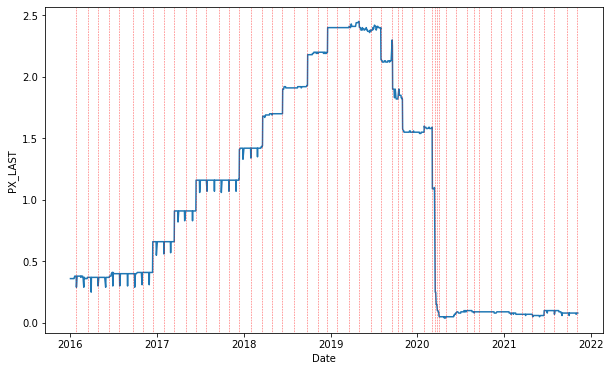

In [47]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=ffr.reset_index()[lambda x:x.Date>'2016-01-01'],x='Date',y='PX_LAST',ax=ax)
for i in stat_total.loc['2016-01-01':].index:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

#### 10-Year US Treasuray Bonds

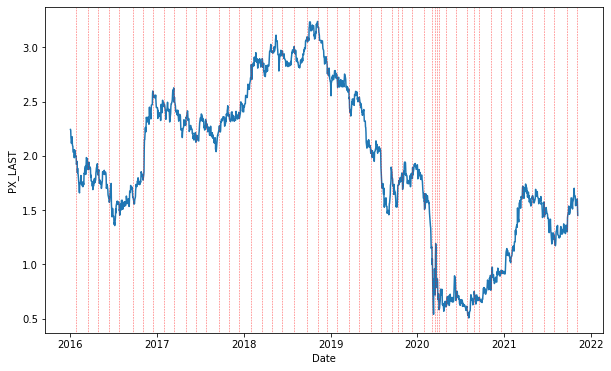

In [48]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=us10year.reset_index()[lambda x:x.Date>'2016-01-01'],x='Date',y='PX_LAST',ax=ax)
for i in stat_total.loc['2016-01-01':].index:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

#### 3-Year US Treasuray Bonds

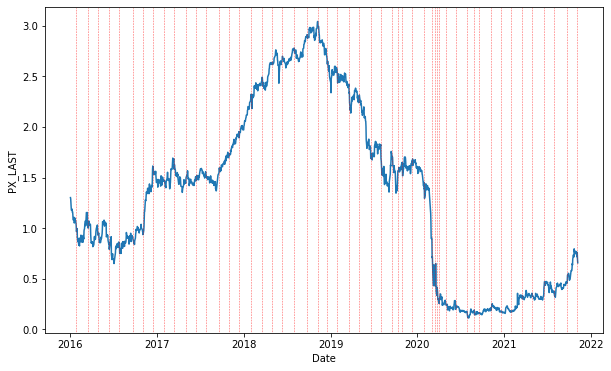

In [49]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=us3year.reset_index()[lambda x:x.Date>'2016-01-01'],x='Date',y='PX_LAST',ax=ax)
for i in stat_total.loc['2016-01-01':].index:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

### 6.2 Random forest (RF) for original X and discrete Y
We first merge data and split data. When spliting data, it is not proper to use random split, as we cannot use data in the future to predict price in the past.

In [50]:
stat_disc=stat_total.merge(y_disc, left_index=True, right_index=True, how='left').dropna()

In [3]:
def train_test_split_time(df,X,y,test_size):
    df1=df.sort_index()
    cutoff=df1.index[int((1-test_size)*len(df1.index))]
    one_day=pd.Timedelta(days=1)
    return df1.loc[:cutoff][X],df1.loc[cutoff+one_day:][X],df1.loc[:cutoff][y],df1.loc[cutoff+one_day:][y]

#### Federal fund rate

In [52]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='ffr', test_size=0.3)

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(max_depth=2,n_estimators=16,max_features='sqrt',class_weight='balanced')
rf.fit(X_train,y_train)
print('Training accuracy:', rf.score(X_train, y_train))
print('Test accuracy:', rf.score(X_test, y_test))

Training accuracy: 0.7573529411764706
Test accuracy: 0.1896551724137931


In [54]:
from sklearn.model_selection import GridSearchCV
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
param_range=np.arange(1,20)
param_grid={'max_depth':param_range,'n_estimators':param_range}
gs=GridSearchCV(estimator=rf,
               param_grid=param_grid,
               scoring='accuracy',
               cv=4)
gs.fit(X_combined,y_combined)
print(gs.best_params_)

{'max_depth': 14, 'n_estimators': 15}


And then we use 5-fold to calculate the accuracy.

In [68]:
from sklearn.model_selection import cross_val_score
rf_best=gs.best_estimator_
scores=cross_val_score(estimator=rf_best,
                      X=X_combined,
                      y=y_combined,
                      cv=5)
print('CV accuracy scores of RF: %s'%scores)

CV accuracy scores of RF: [0.35897436 0.43589744 0.30769231 0.28205128 0.28947368]


In [69]:
(y_combined==0).sum()/len(y_combined)

0.2422680412371134

It can beat the two naive models: 
1. Randomly choose one.
2. Always predict that the price will not change.

Text(0.5, 1.0, 'Feature Importance')

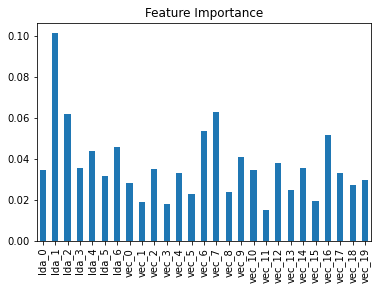

In [70]:
rf_best.fit(X_train,y_train)
fi=rf_best.feature_importances_
fig,ax=plt.subplots()
pd.Series(fi,index=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)]).plot.bar(ax=ax)
ax.set_title('Feature Importance')

In [71]:
def random_forest_grid(X_train, X_test, y_train, y_test):
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((y_train, y_test))
    param_range=np.arange(1,20)
    param_grid={'max_depth':param_range,'n_estimators':param_range}
    gs=GridSearchCV(estimator=rf,
               param_grid=param_grid,
               scoring='accuracy',
               cv=4)
    gs.fit(X_combined,y_combined)
    return gs

def random_forest_test(X_train, X_test, y_train, y_test, estimator):
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((y_train, y_test))
    return cross_val_score(estimator=estimator,
                      X=X_combined,
                      y=y_combined,
                      cv=5)

#### 10-year treasury bond

In [72]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='us10year', test_size=0.3)

In [73]:
gs=random_forest_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'max_depth': 11, 'n_estimators': 2}


In [74]:
rf_best=gs.best_estimator_
scores=random_forest_test(X_train, X_test, y_train, y_test,rf_best)
print('CV accuracy scores of RF: %s'%scores)

CV accuracy scores of RF: [0.48717949 0.41025641 0.46153846 0.53846154 0.47368421]


In [75]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.09278350515463918

It can beat the two naive models: 
1. Randomly choose one.
2. Always predict that the price will not change.

Text(0.5, 1.0, 'Feature Importance')

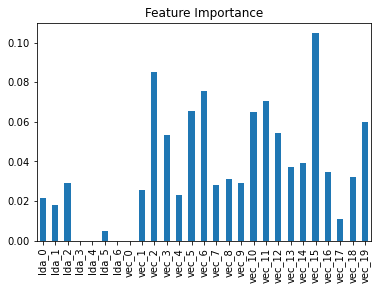

In [76]:
rf_best.fit(X_train,y_train)
fi=rf_best.feature_importances_
fig,ax=plt.subplots()
pd.Series(fi,index=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)]).plot.bar(ax=ax)
ax.set_title('Feature Importance')

#### 3-year treasury bond

In [77]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='us3year', test_size=0.3)

In [78]:
gs=random_forest_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'max_depth': 16, 'n_estimators': 14}


In [79]:
rf_best=gs.best_estimator_
scores=random_forest_test(X_train, X_test, y_train, y_test,rf_best)
print('CV accuracy scores of RF: %s'%scores)

CV accuracy scores of RF: [0.48717949 0.53846154 0.51282051 0.58974359 0.63157895]


In [80]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.07216494845360824

It can also beat the two naive models: 
1. Randomly choose one.
2. Always predict that the price will not change.

Text(0.5, 1.0, 'Feature Importance')

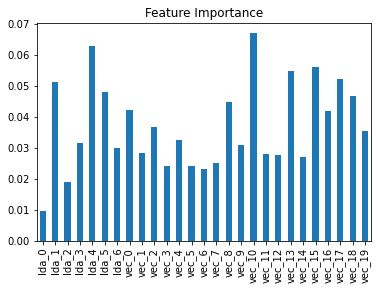

In [81]:
rf_best.fit(X_train,y_train)
fi=rf_best.feature_importances_
fig,ax=plt.subplots()
pd.Series(fi,index=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)]).plot.bar(ax=ax)
ax.set_title('Feature Importance')

###  6.3 RF for principal components of X and discrete Y
We first use the similar methods to merge and split data.

In [82]:
stat_disc_pca=stat_pca_total.merge(y_disc, left_index=True, right_index=True, how='left').dropna()

#### Federal fund rate

In [83]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc_pca, X=list(range(3)), y='ffr', test_size=0.3)

In [84]:
gs=random_forest_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'max_depth': 13, 'n_estimators': 6}


In [90]:
rf_best=gs.best_estimator_
scores=random_forest_test(X_train, X_test, y_train, y_test,rf_best)
print('CV accuracy scores of RF: %s'%scores)

CV accuracy scores of RF: [0.41025641 0.43589744 0.28205128 0.30769231 0.31578947]


In [91]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.2422680412371134

The accuracy is lower than that of the original data.

Text(0.5, 1.0, 'Feature Importance')

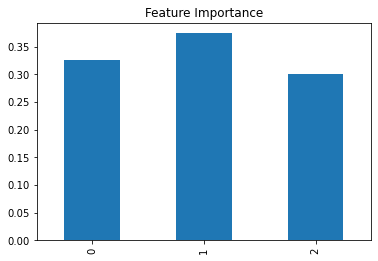

In [92]:
rf_best.fit(X_train,y_train)
fi=rf_best.feature_importances_
fig,ax=plt.subplots()
pd.Series(fi,index=range(3)).plot.bar(ax=ax)
ax.set_title('Feature Importance')

#### 10-year treasury bond

In [93]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc_pca, X=list(range(3)), y='us10year', test_size=0.3)

In [94]:
gs=random_forest_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'max_depth': 12, 'n_estimators': 2}


In [95]:
rf_best=gs.best_estimator_
scores=random_forest_test(X_train, X_test, y_train, y_test,rf_best)
print('CV accuracy scores of RF: %s'%scores)

CV accuracy scores of RF: [0.46153846 0.43589744 0.53846154 0.38461538 0.5       ]


In [96]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.09278350515463918

Text(0.5, 1.0, 'Feature Importance')

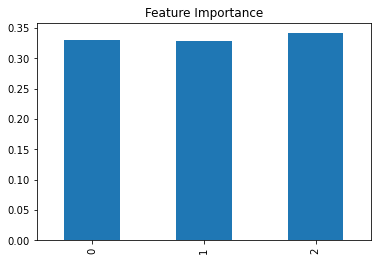

In [97]:
rf_best.fit(X_train,y_train)
fi=rf_best.feature_importances_
fig,ax=plt.subplots()
pd.Series(fi,index=range(3)).plot.bar(ax=ax)
ax.set_title('Feature Importance')

#### 3-year treasury bond

In [98]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc_pca, X=list(range(3)), y='us3year', test_size=0.3)

In [99]:
gs=random_forest_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'max_depth': 15, 'n_estimators': 17}


In [100]:
rf_best=gs.best_estimator_
scores=random_forest_test(X_train, X_test, y_train, y_test,rf_best)
print('CV accuracy scores of RF: %s'%scores)

CV accuracy scores of RF: [0.48717949 0.46153846 0.48717949 0.51282051 0.55263158]


In [101]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.07216494845360824

Text(0.5, 1.0, 'Feature Importance')

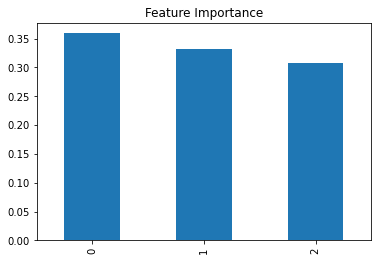

In [102]:
rf_best.fit(X_train,y_train)
fi=rf_best.feature_importances_
fig,ax=plt.subplots()
pd.Series(fi,index=range(3)).plot.bar(ax=ax)
ax.set_title('Feature Importance')

### 6.4 Support vector machine (SVM) for original X and discrete Y
#### Federal fund rate

In [103]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='ffr', test_size=0.3)

In [104]:
from sklearn.svm import SVC

svm=SVC(class_weight='balanced',kernel='rbf',C=1)
svm.fit(X_train,y_train)
print('Training accuracy:', svm.score(X_train, y_train))
print('Test accuracy:', svm.score(X_test, y_test))

Training accuracy: 0.8676470588235294
Test accuracy: 0.39655172413793105


In [105]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
svm_range=(np.ones((9,))*10)**np.arange(-4,5)
param_grid={'C':svm_range}
gs=GridSearchCV(estimator=svm,
               param_grid=param_grid,
               scoring='accuracy',
               cv=4)
gs.fit(X_combined,y_combined)
print(gs.best_params_)

{'C': 0.1}


In [106]:
svm_best=gs.best_estimator_
scores=cross_val_score(estimator=svm_best,
                      X=X_combined,
                      y=y_combined,
                      cv=5)
print('CV accuracy scores of SVM: %s'%scores)

CV accuracy scores of SVM: [0.41025641 0.41025641 0.38461538 0.38461538 0.39473684]


In [107]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.2422680412371134

The result of SVM is even better than Random Forest.

In [108]:
def svm_grid(X_train, X_test, y_train, y_test):
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((y_train, y_test))
    svm_range=(np.ones((9,))*10)**np.arange(-4,5)
    param_grid={'C':svm_range}
    gs=GridSearchCV(estimator=svm,
                   param_grid=param_grid,
                   scoring='accuracy',
                   cv=4)
    gs.fit(X_combined,y_combined)
    return gs

def svm_test(X_train, X_test, y_train, y_test, estimator):
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((y_train, y_test))
    return cross_val_score(estimator=estimator,
                      X=X_combined,
                      y=y_combined,
                      cv=5)

#### 10-year treasury bond

In [109]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='us10year', test_size=0.3)

In [110]:
gs=svm_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'C': 10.0}


In [111]:
svm_best=gs.best_estimator_
scores=svm_test(X_train, X_test, y_train, y_test, svm_best)
print('CV accuracy scores of SVM: %s'%scores)

CV accuracy scores of SVM: [0.46153846 0.46153846 0.33333333 0.53846154 0.47368421]


In [112]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.09278350515463918

#### 3-year treasury bond

In [117]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='us3year', test_size=0.3)

In [118]:
gs=svm_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'C': 100.0}


In [119]:
svm_best=gs.best_estimator_
scores=svm_test(X_train, X_test, y_train, y_test,svm_best)
print('CV accuracy scores of SVM: %s'%scores)

CV accuracy scores of SVM: [0.46153846 0.53846154 0.56410256 0.48717949 0.5       ]


In [120]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.07216494845360824

### 6.5 SVM for principal components of X and discrete Y

#### Federal fund rate

In [121]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc_pca, X=list(range(3)), 
                     y='ffr', test_size=0.3)

In [122]:
gs=svm_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'C': 1000.0}


In [123]:
svm_best=gs.best_estimator_
scores=svm_test(X_train, X_test, y_train, y_test,svm_best)
print('CV accuracy scores of SVM: %s'%scores)

CV accuracy scores of SVM: [0.41025641 0.35897436 0.35897436 0.35897436 0.31578947]


In [124]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.2422680412371134

#### 10-year treasury bond

In [125]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc_pca, X=list(range(3)), 
                     y='us10year', test_size=0.3)

In [126]:
gs=svm_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'C': 0.01}


In [127]:
svm_best=gs.best_estimator_
scores=svm_test(X_train, X_test, y_train, y_test,svm_best)
print('CV accuracy scores of SVM: %s'%scores)

CV accuracy scores of SVM: [0.33333333 0.28205128 0.20512821 0.56410256 0.07894737]


In [128]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.09278350515463918

####  3-year treasury bond

In [134]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc_pca, X=list(range(3)), 
                     y='us10year', test_size=0.3)

In [135]:
gs=svm_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'C': 0.01}


In [136]:
svm_best=gs.best_estimator_
scores=svm_test(X_train, X_test, y_train, y_test,svm_best)
print('CV accuracy scores of SVM: %s'%scores)

CV accuracy scores of SVM: [0.33333333 0.28205128 0.20512821 0.56410256 0.07894737]


In [137]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.09278350515463918

### 6.6 Dense neural network for original X and discrete Y

In [46]:
import keras
from keras import Sequential
from keras.layers import merge, Conv2D, MaxPooling2D, Input, Dense, Flatten, LSTM, Dropout
import pandas as pd
import numpy as np
from tqdm import tqdm

seed=123456

In [47]:
stat_disc = pd.read_excel("stat_disc.xlsx", header=0, index_col=0)
stat_cont = pd.read_excel("stat_cont.xlsx", header=0, index_col=0)

In [125]:
class DenseModelClassification:
    def build_model():
        dense_model = Sequential()
        dense_model.add(Dense(32, activation='relu', input_shape=(len(X_train.iloc[0, :]), ), kernel_initializer=keras.initializers.ones()))
        dense_model.add(Dense(16, activation='relu'))
        dense_model.add(Dense(3, activation='softmax'))
        dense_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return dense_model

#### Federal fund rate

In [126]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='ffr', test_size=0.3)

In [127]:
y_train_reshape = pd.DataFrame(np.zeros([len(y_train), 3]), index=y_train.index)
y_test_reshape = pd.DataFrame(np.zeros([len(y_test), 3]), index=y_test.index)
for i in range(len(y_train)):
    y_train_reshape.iloc[i, y_train[i]+1] = 1
y_train = y_train_reshape

for i in range(len(y_test)):
    y_test_reshape.iloc[i, y_test[i] + 1] = 1
y_test = y_test_reshape

In [128]:
test_accuracy = []
n_iter = 10

In [129]:
for i in range(n_iter):
    dense_model = DenseModelClassification.build_model()
    dense_model.fit(X_train, y_train, epochs=100, verbose=0)
    prediction = dense_model.predict(X_test)
    prediction = (prediction == prediction.max(axis=1, keepdims=1)).astype(float)

    dev = prediction - y_test
    error = 0
    for i in range(len(y_test)):
        error += (abs(dev.iloc[i, 0]) + abs(dev.iloc[i, 1]) + abs(dev.iloc[i, 2]))/2
    test_accuracy.append(1- error / len(dev))
print('mean accuracy: ' + str(np.mean(test_accuracy)))
print('std of accuracy: ' + str(np.std(test_accuracy)))
print('coefficient of variation: ' + str(np.std(test_accuracy) / np.mean(test_accuracy)))

mean accuracy: 0.2982758620689655
std of accuracy: 0.027854300726557767
coefficient of variation: 0.0933843608173613


#### 10-year treasury bond

In [130]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], y='us10year', test_size=0.3)

In [131]:
y_train_reshape = pd.DataFrame(np.zeros([len(y_train), 3]), index=y_train.index)
y_test_reshape = pd.DataFrame(np.zeros([len(y_test), 3]), index=y_test.index)
for i in range(len(y_train)):
    y_train_reshape.iloc[i, y_train[i]+1] = 1
y_train = y_train_reshape

for i in range(len(y_test)):
    y_test_reshape.iloc[i, y_test[i] + 1] = 1
y_test = y_test_reshape

In [132]:
test_accuracy = []
n_iter = 10
for i in range(n_iter):
    dense_model = DenseModelClassification.build_model()
    dense_model.fit(X_train, y_train, epochs=100, verbose=0)
    prediction = dense_model.predict(X_test)
    prediction = (prediction == prediction.max(axis=1, keepdims=1)).astype(float)

    dev = prediction - y_test
    error = 0
    for i in range(len(y_test)):
        error += (abs(dev.iloc[i, 0]) + abs(dev.iloc[i, 1]) + abs(dev.iloc[i, 2]))/2
    test_accuracy.append(1- error / len(dev))
print('mean accuracy: ' + str(np.mean(test_accuracy)))
print('std of accuracy: ' + str(np.std(test_accuracy)))
print('coefficient of variation: ' + str(np.std(test_accuracy) / np.mean(test_accuracy)))

mean accuracy: 0.42931034482758623
std of accuracy: 0.019582442571725076
coefficient of variation: 0.04561372165301423


#### 3-year treasury bond

In [133]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], y='us3year', test_size=0.3)

In [134]:
y_train_reshape = pd.DataFrame(np.zeros([len(y_train), 3]), index=y_train.index)
y_test_reshape = pd.DataFrame(np.zeros([len(y_test), 3]), index=y_test.index)
for i in range(len(y_train)):
    y_train_reshape.iloc[i, y_train[i]+1] = 1
y_train = y_train_reshape

for i in range(len(y_test)):
    y_test_reshape.iloc[i, y_test[i] + 1] = 1
y_test = y_test_reshape

In [135]:
test_accuracy = []
n_iter = 10
for i in range(n_iter):
    dense_model = DenseModelClassification.build_model()
    dense_model.fit(X_train, y_train, epochs=100, verbose=0)
    prediction = dense_model.predict(X_test)
    prediction = (prediction == prediction.max(axis=1, keepdims=1)).astype(float)

    dev = prediction - y_test
    error = 0
    for i in range(len(y_test)):
        error += (abs(dev.iloc[i, 0]) + abs(dev.iloc[i, 1]) + abs(dev.iloc[i, 2]))/2
    test_accuracy.append(1- error / len(dev))
print('mean accuracy: ' + str(np.mean(test_accuracy)))
print('std of accuracy: ' + str(np.std(test_accuracy)))
print('coefficient of variation: ' + str(np.std(test_accuracy) / np.mean(test_accuracy)))

mean accuracy: 0.34310344827586203
std of accuracy: 0.047185973046220735
coefficient of variation: 0.13752695661712577


### 6.7 Dense neural network for original X and continuous Y

In [148]:
class DenseModelRegression:
    def build_model():
        dense_model = Sequential()
        dense_model.add(Dense(16, activation='relu', input_shape=(len(X_train.iloc[0, :]), ), kernel_initializer='random_normal'))
        dense_model.add(Dense(8, activation='relu'))
        dense_model.add(Dense(4, activation='relu'))
        dense_model.add(Dense(1))
        dense_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
        return dense_model

In [149]:
import matplotlib.pyplot as plt
def nn_plot(y_pred, y_test, title):
    plt.plot(y_test.index.values, y_test, color="navy", label="y_test")
    plt.plot(y_test.index.values, y_pred, color="red", label="y_pred")
    plt.title(title)
    plt.xlabel('date')
    plt.ylabel('y')
    plt.legend(loc="upper right")
    plt.show()

#### Federal fund rate

In [150]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_cont, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], y='ffr', test_size=0.3)

In [151]:
test_error = []
n_iter = 10
for i in range(n_iter):
    dense_model = DenseModelRegression.build_model()
    dense_model.fit(X_train, y_train, epochs=100, verbose=0)
    prediction = dense_model.predict(X_test)[:, 0]
    error = 0
    for i in range(len(y_test)):
        error += (prediction - y_test)**2
    test_error.append(error / len(y_test))
print('MSE: ' + str(np.mean(test_error)))
print('std of MSE: ' + str(np.std(test_error)))

MSE: 0.005533819457294469
std of MSE: 0.01945886165029504


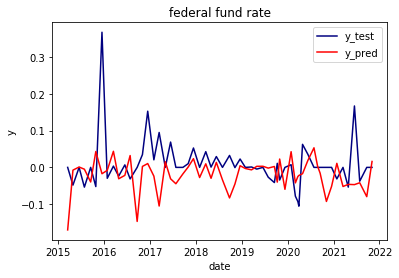

In [152]:
nn_plot(prediction, y_test, title='federal fund rate')

#### 10-year treasury bond

In [153]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_cont, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], y='us10year', test_size=0.3)

In [154]:
test_error = []
n_iter = 10
for i in range(n_iter):
    dense_model = DenseModelRegression.build_model()
    dense_model.fit(X_train, y_train, epochs=100, verbose=0)
    prediction = dense_model.predict(X_test)[:, 0]
    error = 0
    for i in range(len(y_test)):
        error += (prediction - y_test)**2
    test_error.append(error / len(y_test))
print('MSE: ' + str(np.mean(test_error)))
print('std of MSE: ' + str(np.std(test_error)))

MSE: 0.0006545004850668901
std of MSE: 0.002392595825838458


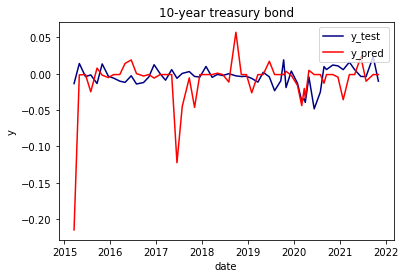

In [155]:
nn_plot(prediction, y_test, title='10-year treasury bond')

#### 3-year treasury bond

In [156]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_cont, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], y='us3year', test_size=0.3)

In [157]:
test_error = []
n_iter = 10
for i in range(n_iter):
    dense_model = DenseModelRegression.build_model()
    dense_model.fit(X_train, y_train, epochs=100, verbose=0)
    prediction = dense_model.predict(X_test)[:, 0]
    error = 0
    for i in range(len(y_test)):
        error += (prediction - y_test)**2
    test_error.append(error / len(y_test))
print('MSE: ' + str(np.mean(test_error)))
print('std of MSE: ' + str(np.std(test_error)))

MSE: 0.0009155023564106135
std of MSE: 0.0017585036785509184


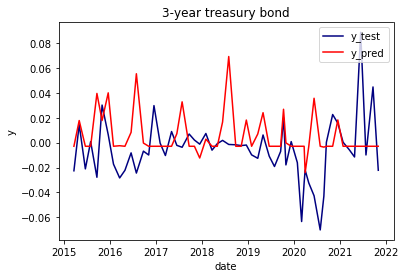

In [158]:
nn_plot(prediction, y_test, title='3-year treasury bond')

## 4. Influence of minutes
### 4.1 Plot
Again, we use red line to mark the time when minutes were publicated.
#### Data Preperation

In [584]:
mi=pd.read_excel('vec_min.xlsx')
mi['st_time']=pd.to_datetime(mi.file.str[11:])
mi['pub_time']=pd.to_datetime(mi.pub_time.astype(str))
mi=mi.drop('file',axis=1).merge(
    st.drop('file',axis=1),
    left_on='st_time',right_on='dt',suffixes=('_mi','_st'))

In [585]:
mi

,date_mi,pub_time,0_mi,1_mi,2_mi,3_mi,4_mi,5_mi,6_mi,7_mi,...,12_st,13_st,14_st,15_st,16_st,17_st,18_st,19_st,cos_st,dt
0,20160127,2016-02-17,-0.017573,-0.004033,0.017484,0.000018,-0.006594,-0.022385,-0.005872,0.007935,...,-0.013769,-0.012264,-0.006189,0.001022,0.024422,-0.013350,-0.014459,-0.010979,0.125150,2016-01-27
1,20160316,2016-04-06,-0.024023,-0.014612,-0.000676,-0.021333,-0.012202,0.023846,0.022783,0.009473,...,-0.010741,-0.020612,-0.015346,0.023449,-0.020201,-0.003289,-0.004583,0.022650,-0.368989,2016-03-16
2,20160427,2016-05-18,-0.009483,-0.021400,-0.020217,-0.020622,-0.017765,-0.013586,-0.010085,0.024625,...,0.014618,-0.007546,-0.015265,-0.000853,-0.023666,0.018686,-0.010650,0.005748,-0.336561,2016-04-27
3,20160615,2016-07-06,0.005206,-0.024851,-0.021739,0.023006,0.021305,0.015038,0.011444,-0.001719,...,-0.008302,0.021224,-0.016932,-0.004973,-0.006390,0.021398,-0.006968,0.008954,0.231531,2016-06-15
4,20160727,2016-08-17,0.337611,-0.119590,0.032108,0.305054,0.142185,-0.176148,-0.243425,0.138302,...,0.024449,0.000639,-0.009604,-0.013218,-0.015366,0.012879,0.001500,0.009440,0.158570,2016-07-27
5,20160921,2016-10-12,0.010702,0.015152,-0.024089,-0.006218,0.017446,-0.021784,0.023812,-0.002408,...,0.018991,0.006694,0.018007,-0.004369,0.021494,0.001003,0.013668,0.001637,-0.248798,2016-09-21
6,20161102,2016-11-23,-0.007434,-0.015474,0.017831,-0.007604,-0.021326,0.018456,-0.024330,0.006877,...,0.007470,-0.016150,-0.012325,-0.008902,0.007133,-0.001255,-0.012249,-0.011826,-0.163162,2016-11-02
7,20161214,2017-01-04,0.003255,0.022834,-0.001323,-0.003383,0.024815,-0.012722,-0.008110,0.018393,...,0.004174,-0.018387,-0.018672,-0.011373,-0.001620,0.006303,0.015053,-0.013348,-0.292903,2016-12-14
8,20170201,2017-02-22,0.010044,-0.009910,0.014483,0.001060,0.013946,-0.004390,-0.008672,0.022617,...,-0.021263,0.013186,-0.005077,-0.016906,-0.014289,0.003382,0.007474,-0.000253,-0.068139,2017-02-01
9,20170315,2017-04-05,-0.023711,0.023908,0.010165,0.019468,0.012558,-0.022145,0.006918,0.015425,...,-0.006080,0.006902,0.020921,0.002148,0.021830,-0.018999,-0.008588,0.015147,-0.050437,2017-03-15


#### Federal fund rate
We can find that minutes also have some impact on the federal fund rate, but not as strong as that of statements, because the most of the information in the minutes is already included in the statements and reflected by the market.

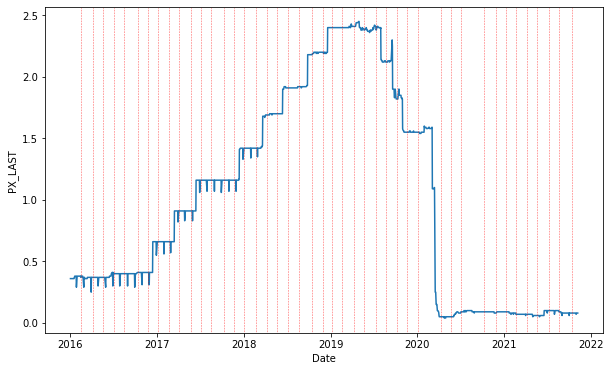

In [586]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=ffr.reset_index(),x='Date',y='PX_LAST',ax=ax)
for i in mi.pub_time:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

#### Bloomberg US treasury index and S&P 500 index
Influence can still be found in some cases.

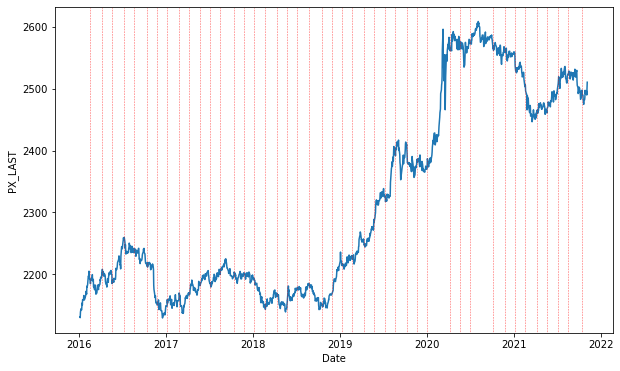

In [587]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=bond.reset_index(),x='Date',y='PX_LAST',ax=ax)
for i in mi.pub_time:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

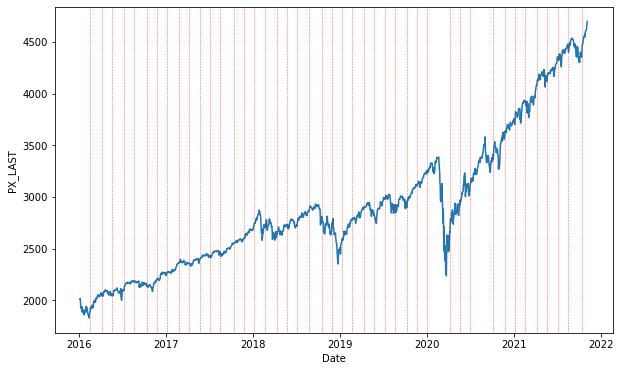

In [588]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=spx.reset_index(),x='Date',y='PX_LAST',ax=ax)
for i in mi.pub_time:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

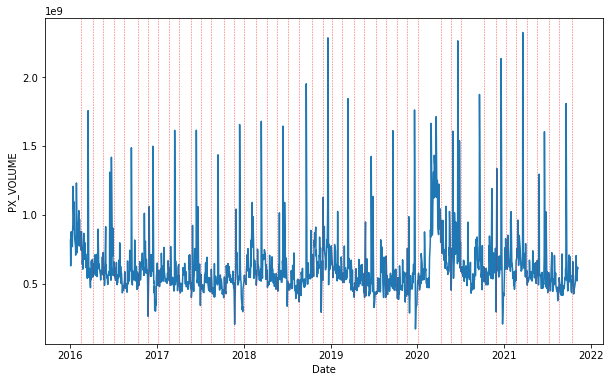

In [589]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=spx.reset_index(),x='Date',y='PX_VOLUME',ax=ax)
for i in mi.pub_time:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

### 4.2 Prediction model

Again, we use the explained variable defined previously.
$$ Y=F\left(\left(\frac{1}{W}\sum_{i=1}^W V_{T+i}-\frac{1}{W}\sum_{i=1}^W V_{T-i}\right)/\left(\frac{1}{W}\sum_{i=1}^W V_{T-i}\right)\right)$$
However, minutes data itself is not enough to predict the influence of minutes, so we must take the information in the statements into consideration. We use the vectors of minutes minutes the vectors of statements as $X$.

#### Calculate X and Y

In [642]:
mi_list=[str(i)+'_mi' for i in range(20)]
st_list=[str(i)+'_st' for i in range(20)]
out_list=[str(i)+'_out' for i in range(20)]
mi[out_list]=mi[mi_list].values-mi[st_list].values
tree_data=mi.set_index('pub_time').merge(y,left_index=True,right_index=True,how='left').dropna()

#### Federal fund rate

In [643]:
X_train, X_test, y_train, y_test =\
    train_test_split(tree_data[out_list], tree_data.ffr, test_size=0.3, random_state=0)
dt=DecisionTreeClassifier(max_depth=2,class_weight='balanced')
dt.fit(X_train,y_train)
print('Training accuracy:', dt.score(X_train, y_train))
print('Test accuracy:', dt.score(X_test, y_test))

Training accuracy: 0.8333333333333334
Test accuracy: 0.5


In [644]:
rf=RandomForestClassifier(max_depth=2,n_estimators=4,max_features='sqrt',class_weight='balanced')
rf.fit(X_train,y_train)
print('Training accuracy:', rf.score(X_train, y_train))
print('Test accuracy:', rf.score(X_test, y_test))

Training accuracy: 0.9333333333333333
Test accuracy: 0.5


In [645]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
param_range=np.arange(1,20)
param_grid={'max_depth':param_range,'n_estimators':param_range}
gs=GridSearchCV(estimator=rf,
               param_grid=param_grid,
               scoring='accuracy',
               cv=4)
gs.fit(X_combined,y_combined)
print(gs.best_params_)

/Users/mrzhai/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


{'max_depth': 2, 'n_estimators': 9}


In [646]:
scores=cross_val_score(estimator=rf_best,
                      X=X_combined,
                      y=y_combined,
                      cv=3)
print('CV accuracy scores of LR: %s'%scores)

CV accuracy scores of LR: [0.86666667 0.86666667 0.85714286]


/Users/mrzhai/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


In [651]:
confusion_matrix(y_test,rf_best.predict(X_test.values))

array([[0, 1, 0],
       [1, 6, 5],
       [0, 1, 0]])

# References

<font color=black size=3 face=times><p>[1] Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent Dirichlet Allocation. *the Journal of Machine Learning Research*, *3*, 993-1022.</p>
    <p>[2] Le, Q., & Mikolov, T. (2014). Distributed Representations of Sentences and Documents. *Proceedings of the 31st International Conference on Machine Learning, 14*, 1188-1196.<br>